In [38]:
#________________importing libraries_______________
import pandas as pd
import joblib
import shap
import numpy as np
#from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [39]:
#         dataset
df = pd.read_csv(
    "data/processed/dataset.csv",
    low_memory=False
)
print(df.head(5))

   match_id        date        batter         batting_team      bowling_team  \
0    336018  2008-05-14      MS Dhoni  Chennai Super Kings    Mumbai Indians   
1    336020  2008-05-15      V Sehwag     Delhi Daredevils   Deccan Chargers   
2    336020  2008-05-15  AC Gilchrist      Deccan Chargers  Delhi Daredevils   
3    336020  2008-05-15     G Gambhir     Delhi Daredevils   Deccan Chargers   
4    336020  2008-05-15      S Dhawan     Delhi Daredevils   Deccan Chargers   

              venue  rolling_avg_10  venue_avg  pvt_avg   pvp_avg  career_avg  \
0  Wankhede Stadium            33.2  17.857143     30.0  0.000000   32.111111   
1  Feroz Shah Kotla            28.7  28.272727     94.0  0.000000   31.888889   
2  Feroz Shah Kotla            32.2  18.000000      8.0  1.454545   34.222222   
3  Feroz Shah Kotla            42.5  37.111111     12.0  2.000000   38.444444   
4  Feroz Shah Kotla            28.4  30.076923     25.0  1.714286   24.000000   

   next_match_runs  
0          

In [40]:
df = df.sort_values("date").reset_index(drop=True)

# baseline for batsman

x = df[['rolling_avg_10','venue_avg','pvt_avg','pvp_avg','career_avg']]
y = df['next_match_runs']

In [41]:
# train & test split
split = int(len(df) * 0.8)

x_train, x_test = x.iloc[:split], x.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

print("y_test sample:", y_test.head(10).tolist())

y_test sample: [0.0, 41.0, 59.0, 16.0, 30.0, 26.0, 8.0, 0.0, 68.0, 54.0]


In [42]:
baseline_pred = x_test['rolling_avg_10']
print(baseline_pred)

9351      8.3
9352     13.2
9353     26.7
9354     40.4
9355     14.3
         ... 
11684    20.0
11685    29.0
11686    19.1
11687    25.9
11688    28.6
Name: rolling_avg_10, Length: 2338, dtype: float64


In [43]:
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))
baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_r2 = r2_score(y_test, baseline_pred)

print("Baseline RMSE:",baseline_rmse)
print("Baseline MAE:",baseline_mae)
print("Baseline R2:",baseline_r2)

Baseline RMSE: 23.032489790965183
Baseline MAE: 17.62378100940975
Baseline R2: 0.045167766472320126


In [44]:
# linear regression
lr = LinearRegression()
lr.fit(x_train, y_train)
lr_pred = lr.predict(x_test)
print("Linear Regression")
print("RMSE:", np.sqrt(mean_squared_error(y_test, lr_pred)))
print("MAE :", mean_absolute_error(y_test, lr_pred))
print("R2  :", r2_score(y_test, lr_pred))


Linear Regression
RMSE: 22.302609296240856
MAE : 16.975047445728418
R2  : 0.10472460336559197


In [45]:
# Random forest 
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=8,
    random_state=42
)
rf.fit(x_train, y_train)
rf_pred = rf.predict(x_test)

In [46]:
#    Xgboost
xgb = XGBRegressor(
    n_estimators=400,
    max_depth=3,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb.fit(x_train, y_train)
xgb_pred = xgb.predict(x_test)

In [47]:
# lightgbm
lgb = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5
)
lgb.fit(x_train,y_train)
lgb_pred = lgb.predict(x_test)
    

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1264
[LightGBM] [Info] Number of data points in the train set: 9351, number of used features: 5
[LightGBM] [Info] Start training from score 22.037215
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [48]:
  #   evaluation's for models
def evaluate(y_true, y_pred, name):
  print(f"\n{name}")
  print("RMSE:",np.sqrt(mean_squared_error(y_true, y_pred)))
  print("MAE:",mean_absolute_error(y_true, y_pred))
  print("R2:",r2_score(y_true, y_pred))

evaluate(y_test, rf_pred, "Random Forest")
evaluate(y_test, xgb_pred, "XGBoost")
evaluate(y_test, lgb_pred, "LightGBM")


Random Forest
RMSE: 22.44627993387902
MAE: 17.060579102093836
R2: 0.0931529457331024

XGBoost
RMSE: 22.49247329941559
MAE: 17.05867621774241
R2: 0.08941660975963417

LightGBM
RMSE: 22.808933580610624
MAE: 17.26050853873325
R2: 0.06361325363878223


In [49]:
#         Hyper Parameter Tuning for RFR
#from sklearn.model_selection import GridSearchCV
#from sklearn.ensemble import RandomForestRegressor

#param_grid = {
 #   'n_estimators': [100,200],
  #  'max_depth': [5,7],
   # 'min_samples_split': [2, 5],
    #'min_samples_leaf': [1, 2]
#}
#grid = GridSearchCV(
   # estimator=RandomForestRegressor(
    #    random_state=42,
#),
 #   param_grid=param_grid,
  #  cv=2,
   # scoring='neg_root_mean_squared_error',
    #n_jobs=-1
#)

#grid.fit(x_train, y_train)

#print("Best Parameters:", grid.best_params_)
#print("Best RMSE:", -grid.best_score_)

#best_rf = grid.best_estimator_
#best_rf.fit(x_train, y_train)

In [50]:
# hyper parameter tuning using xgboost
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

param_grid = {
    'max_depth':[3, 5],
    'learning_rate':[0.03,0.05],
    'n_estimators': [200,300]
}

grid = GridSearchCV(
    estimator=XGBRegressor(
        random_state=42,
        objective='reg:squarederror'
    ),
    param_grid=param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
grid.fit(x_train, y_train)

print("Best Parameters:",grid.best_params_)
print("Best RMSE:", -grid.best_score_)

best_xgb = grid.best_estimator_
best_xgb.fit(x_train, y_train)


Best Parameters: {'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 200}
Best RMSE: 20.83863316274908


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes

 97%|=================== | 2273/2338 [00:13<00:00]       

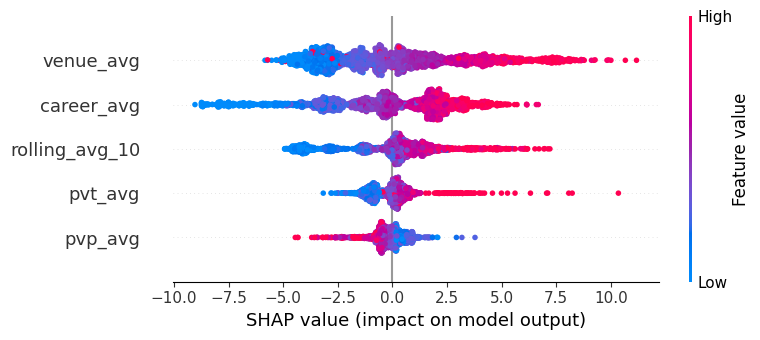

['shap_explainer.pkl']

In [51]:
# shap values for model prediction
import shap
explainer = shap.Explainer(best_xgb,x_train)
shap_values = explainer(x_test)
shap.summary_plot(shap_values, x_test)
joblib.dump(explainer,"shap_explainer.pkl")

In [52]:
#___________Random Forest SHAP______
#rf_explainer = shap.Explainer(best_rf,x_train)
#rf_shap_values= rf_explainer(x_test)
#shap.summary_plot(rf_shap_values, x_test)


In [53]:
joblib.dump(best_xgb,"xgb_model.joblib")
print("xgb_model.joblib saved sucessfully!")

xgb_model.joblib saved sucessfully!


In [54]:
import pandas as pd

bowler_df = pd.read_csv(
    "data/processed/bowler_dataset.csv",
    low_memory=False
)

print(bowler_df.head())

   match_id        date     bowler                 bowling_team  \
0    335982  2008-04-18     Z Khan  Royal Challengers Bangalore   
1    335982  2008-04-18   CL White  Royal Challengers Bangalore   
2    335982  2008-04-18   I Sharma        Kolkata Knight Riders   
3    335982  2008-04-18  JH Kallis  Royal Challengers Bangalore   
4    335982  2008-04-18    P Kumar  Royal Challengers Bangalore   

                  batting_team                  venue  rolling_avg_wickets  \
0        Kolkata Knight Riders  M Chinnaswamy Stadium                  1.0   
1        Kolkata Knight Riders  M Chinnaswamy Stadium                  0.0   
2  Royal Challengers Bangalore  M Chinnaswamy Stadium                  1.0   
3        Kolkata Knight Riders  M Chinnaswamy Stadium                  1.0   
4        Kolkata Knight Riders  M Chinnaswamy Stadium                  0.0   

   venue_avg_wickets  opponent_wickets  bowler_career_wickets_avg  \
0           1.291667          1.400000                   0.

In [55]:
# baseline for bowler
X_bowler = bowler_df[['rolling_avg_wickets','venue_avg_wickets','opponent_wickets',
        'bowler_career_wickets_avg'
            ]]
y_bowler = bowler_df['next_match_wicket']

In [56]:
bowler_df = bowler_df.sort_values("date").reset_index(drop=True)

# Time-based split
split = int(len(df) * 0.8)

#Xb_train, Xb_test = X_bowler[:split], X_bowler[split:]
#yb_train, yb_test = y_bowler[:split], y_bowler[split:]
Xb_train = X_bowler.iloc[:split]
Xb_test  = X_bowler.iloc[split:]

yb_train = y_bowler.iloc[:split]
yb_test  = y_bowler.iloc[split:]

In [57]:
baseline_bowler_pred = Xb_test['rolling_avg_wickets']
print(baseline_bowler_pred.head())

9351    0.0
9352    1.4
9353    0.2
9354    1.0
9355    1.6
Name: rolling_avg_wickets, dtype: float64


In [58]:
baseline_bowler_rmse = np.sqrt(mean_squared_error(yb_test, baseline_bowler_pred))
baseline_bowler_mae  = mean_absolute_error(yb_test, baseline_bowler_pred)
baseline_bowler_r2   = r2_score(yb_test, baseline_bowler_pred)

print("Bowler Baseline RMSE:", baseline_bowler_rmse)
print("Bowler Baseline MAE :", baseline_bowler_mae)
print("Bowler Baseline R2  :", baseline_bowler_r2)


Bowler Baseline RMSE: 1.1605596049991014
Bowler Baseline MAE : 0.9085540482342808
Bowler Baseline R2  : -0.14126794171453882


In [59]:
# Random forest 
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=8,
    random_state=42,
    n_jobs=1,
)
rf.fit(Xb_train, yb_train)
rf_pred = rf.predict(Xb_test)

In [60]:
xgb = XGBRegressor(
    n_estimators=400,
    max_depth=3,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb.fit(Xb_train, yb_train)
xgb_pred = xgb.predict(Xb_test)

In [61]:
# lightgbm
lgb = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5
)
lgb.fit(Xb_train,yb_train)
lgb_pred = lgb.predict(Xb_test)
    

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 568
[LightGBM] [Info] Number of data points in the train set: 9351, number of used features: 4
[LightGBM] [Info] Start training from score 0.990482
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

In [62]:
  #   evaluation's for models
def evaluate(yb_true, yb_pred, name):
  print(f"\n{name}")
  print("RMSE:",np.sqrt(mean_squared_error(yb_true, yb_pred)))
  print("MAE:",mean_absolute_error(yb_true, yb_pred))
  print("R2:",r2_score(yb_true, yb_pred))

evaluate(yb_test, rf_pred, "Random Forest")
evaluate(yb_test, xgb_pred, "XGBoost")
evaluate(yb_test, lgb_pred, "LightGBM")


Random Forest
RMSE: 1.0709944083082321
MAE: 0.8395772160600968
R2: 0.028087597021683397

XGBoost
RMSE: 1.0684528921275753
MAE: 0.8376930279498415
R2: 0.0326949044270205

LightGBM
RMSE: 1.0755947209004533
MAE: 0.8450526498470754
R2: 0.019720226776356875


In [63]:
#from sklearn.model_selection import GridSearchCV
#from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#param_grid = {
 #   'n_estimators': [100, 200], 
  #  'max_depth': [5, 7],      
   # 'min_samples_split': [2, 5],   
    #'min_samples_leaf': [1, 2],     
   # 'max_features': ['sqrt', 'log2'] 
#}

#rf_base = RandomForestRegressor(
 #   random_state=42,
  #  n_jobs=1  
#)
#rf_grid = GridSearchCV(
 #   estimator=rf_base,
  #  param_grid=param_grid,
   # cv=2,                          
    #scoring='neg_root_mean_squared_error',
    #n_jobs=-1,                      
#)
#rf_grid.fit(Xb_train, yb_train)

#print("Best Parameters:", rf_grid.best_params_)
#print("Best RMSE", -rf_grid.best_score_)

# ---------------- Train final tuned model ----------------
#best_rf_bowler = rf_grid.best_estimator_
#best_rf_bowler.fit(Xb_train, yb_train)


In [64]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
xgb_base = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    tree_method="hist",   
    n_jobs=2              
)
param_grid = {
    "max_depth": [3, 4],
    "learning_rate": [0.03, 0.05],
    "n_estimators": [200, 300],
    "subsample": [0.9],
    "colsample_bytree": [0.9],
    "reg_lambda": [1.0, 2.0]
}

xgb_grid = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    cv=2,
    scoring="neg_root_mean_squared_error",
    verbose=1,
    n_jobs=1  
)

xgb_grid.fit(Xb_train, yb_train)

print("Best Parameters:", xgb_grid.best_params_)
print("Best RMSE:", -xgb_grid.best_score_)

# ---------------- Train final tuned model ----------------
best_xgb_bowler = xgb_grid.best_estimator_
best_xgb_bowler.fit(Xb_train, yb_train)


Fitting 2 folds for each of 16 candidates, totalling 32 fits
Best Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 200, 'reg_lambda': 2.0, 'subsample': 0.9}
Best RMSE: 1.034459020741469


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.9
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [65]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Predict on test set
bowler_tuned_pred = best_xgb_bowler.predict(Xb_test)

rmse_b = np.sqrt(mean_squared_error(yb_test, bowler_tuned_pred))
mae_b  = mean_absolute_error(yb_test, bowler_tuned_pred)
r2_b   = r2_score(yb_test, bowler_tuned_pred)

print("\nTuned XGB Bowler – Test Set Performance")
print("RMSE:", rmse_b)
print("MAE :", mae_b)
print("R2  :", r2_b)



Tuned XGB Bowler – Test Set Performance
RMSE: 1.0654404025342776
MAE : 0.8351003101687561
R2  : 0.038141824112426614


In [66]:
# ----- BOWLER: Random Forest SHAP  -----
#rf_explainer = shap.TreeExplainer(best_rf_bowler) 
#rf_shap = rf_explainer(Xb_test)
#shap.summary_plot(rf_shap, Xb_test)


In [67]:
#import shap
#xgb_explainer = shap.Explainer(best_xgb_bowler)
#xgb_shap = xgb_explainer(Xb_test)
#shap.summary_plot(xgb_shap, Xb_test)
#explainer = joblib.load("shap_explainer_bowler.pkl")


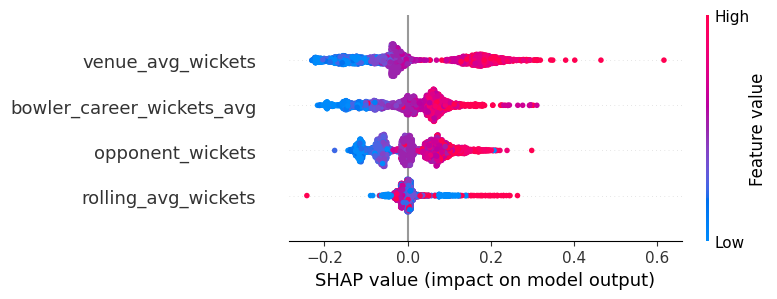

['shap_explainer_bowler.pkl']

In [68]:
import shap
import joblib

xgb_explainer_bowler = shap.Explainer(best_xgb_bowler)
xgb_shap = xgb_explainer_bowler(Xb_test)
shap.summary_plot(xgb_shap, Xb_test)
joblib.dump(xgb_explainer_bowler, "shap_explainer_bowler.pkl")


In [69]:
joblib.dump(best_xgb_bowler, "xgb_bowler_model.joblib")
print("xgb_bowler_model.joblib saved successfully!")


xgb_bowler_model.joblib saved successfully!
